In [ ]:
#Different EEG Augmentation functions
#https://github.com/braindecode/braindecode.git

#TorchEEG manuell import:
#https://github.com/torcheeg/torcheeg.git

#SimCLR TorchEEG:
#https://torcheeg.readthedocs.io/en/latest/generated/torcheeg.trainers.SimCLRTrainer.html#torcheeg.trainers.SimCLRTrainer

In [ ]:
!pip install -r requirements.txt

In [ ]:
'''
Task to DO:

Train on Deap, SeedIV
Downstream on Seed 

Use different batch_size: 512 vs 1024
Use different Augmentation:
Random Noise vs EEGNoise

Raw vs DifferentialEntropyFeature. 

Predict on Trials, vs predict on leave one Subj out

'''

#Experiment1:
'''
Train on Deap, SeedIV
Use Differntial Entropy
Batch_size: 512
X1: Random_Noise std 0.1
X2: Random_Noise std 0.4
Question: Does it create meaningful representations for Downstream on SEED?
'''

In [1]:
#Data_paths
DATA_PATH = './' #where data is saved
TMP_DATA = './Tmp_Datasets'
CHECKPOINT_PATH = './saved_models' # Path to the folder where the pretrained models are saved

# Path to the folder where the training dataset is located
SEED_PATH = './SEED/SEED_EEG/ExtractedFeatures/Subj'
SEEDiv_PATH = './SEED/SEED_IV/ExtractedFeatures'

In [2]:
import os
from copy import deepcopy
NUM_WORKERS = os.cpu_count()
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

gpus = [0]
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
print(f'NUM_WORKERS: {NUM_WORKERS}')

import numpy as np
import io
import itertools
import random
import math
from typing import Dict, List, Union

#Import Pytorch
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.nn.functional import pad
    from torch import Tensor
    from torch.fft import fft, ifft
    import torch.optim as optim
    import sklearn
    import seaborn 

except ModuleNotFoundError: 
    !pip install seaborn 
    !pip install torch
    !pip install scikit-learn
    import seaborn 
    import sklearn
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.nn.functional import pad
    from torch import Tensor
    import torch.optim as optim
    from torch.fft import fft, ifft
# PyTorch Lightning
try:
    import lightning.pytorch as pl
    #import pytorch_lightning as pl
    import torchmetrics
    import torcheeg
    import wandb
    
    
except ModuleNotFoundError: 
    !pip install wandb
    !pip install comet-ml
    !pip install lightning
    #!pip install --quiet pytorch-lightning>=1.4
    !pip install torcheeg
    !pip install torchmetrics
    import wandb
    #import comet_ml
    import lightning.pytorch as pl
    #import pytorch_lightning as pl
    import torcheeg
    import torchmetrics


from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import GradientAccumulationScheduler, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

#from pytorch_lightning.loggers import WandbLogger
#from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


from typing import Any, Tuple, List
from torcheeg.datasets import SEEDDataset, DEAPDataset
from torcheeg import transforms, model_selection


#Create custom dataset:(inherits from torch.utils.data.Dataset)
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.optimizer import Optimizer, required

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import scipy
import scipy.io as scio #for loading raw EEG

import matplotlib
import matplotlib.pyplot as plt
import mne

import PIL

from matplotlib import colors
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle
from pylab import cm
import pathlib
from tqdm import tqdm



#Local imports 
from Plotting import PlotEEG
from Datasets import create_dataset
from Augmentations import ContrastiveTransformations
from AllModels import ArjunViT, Trainer_class2

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

NUM_WORKERS: 96


2023-12-04 17:15:12,628 DEBUG MainThread git.cmd Popen(['git', 'version'], cwd=/workspace, stdin=None, shell=False, universal_newlines=False)
2023-12-04 17:15:12,630 DEBUG MainThread git.cmd Popen(['git', 'version'], cwd=/workspace, stdin=None, shell=False, universal_newlines=False)
2023-12-04 17:15:12,642 DEBUG MainThread wandb.docker.auth Trying paths: ['/root/.docker/config.json', '/root/.dockercfg']
2023-12-04 17:15:12,643 DEBUG MainThread wandb.docker.auth No config file found
2023-12-04 17:15:12,692 DEBUG MainThread sentry_sdk.errors [Tracing] Create new propagation context: {'trace_id': 'fc526cfc106b4dec8938824b2e50a37c', 'span_id': 'bf2f435d75905b1a', 'parent_span_id': None, 'dynamic_sampling_context': None}


Mon Dec  4 17:15:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:52:00.0 Off |                    0 |
|  0%   36C    P0              75W / 300W |    348MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
'''
Parameter
'''

#EEG - Data:
chunk_size=200 #length of a sample
channels = 62
overlap=0 

#NonSSL Models:
nr_devices = 'auto'
batch_size=64
nr_classes=3 #Number of target classes
nr_epochs=30
lr=4e-4  # Conformer paper uses 0.0002
weight_decay=1e-3

#SSL-only Model
batch_sizeSSL = 1024 #based on https://arxiv.org/pdf/2002.05709.pdf
lrSSL= 5e-4 #0.0001 
weight_decaySSL = 1e-6 #based on https://arxiv.org/pdf/2002.05709.pdf
temperatureSSL = 0.05 #based on mohsenvand2020a

#https://arxiv.org/pdf/2007.16104.pdf
#The Adam optimizer [50] with β1 = 0.9 and β2 = 0.999 and learning rate 5 × 10−4 was used.

#https://arxiv.org/pdf/2109.09559.pdf
#We used an Adam optimizer [85] with a cosine annealing learning rate scheduler and a three-time warm restart [86]. 
#The initial learning rate was set to 0.0007, and the weight decay was set to 0.015 empirically. 
'''
In the contrastive learning procedure, we used stratified
normalization [84] during training. In stratified normalization, we concatenated the same channel of different samples from one subject in the minibatch together and conducted z-score normalization. The stratified normalization
was applied to inputs of the base encoder, outputs of average pooling, and outputs of the temporal convolution in
the projector. F
'''

if str(device).startswith("cuda"):
    torch.set_float32_matmul_precision('high') #Increase performance
    
#Logger
project_name='Experiment_11'
import wandb
wandb.login()


#198d0b46f74d1861672c12c46489054b043161f2

## Baseline 

In [4]:
#Leave one out
path = './SEED/SEED_EEG/ExtractedFeatures/Subj'
from torcheeg.datasets import SEEDFeatureDataset
SEED_PATH_Subj = 'SEED_PATH_Subj'
Datasets = []
for i in range(1,16):
    name = SEED_PATH_Subj + str(i)
    file_path = path + str(i)
    print(name)
    
    SEED_dataset_path = os.path.join(TMP_DATA, name)
    Datasets.append(SEEDFeatureDataset(
                      io_path=SEED_dataset_path, #location of loaded and transformed dataset
                      root_path=file_path, #location of original dataset 
                      feature=['de_movingAve'],
                      offline_transform=transforms.Compose([
                                              transforms.BaselineRemoval(),
                                              transforms.ToTensor(),
                                              transforms.To2d(),
                                              transforms.MeanStdNormalize(),
                                              ]),
                                          label_transform=transforms.Compose([
                                              transforms.Select('emotion'),
                                              transforms.Lambda(lambda x: x + 1)]),
                                           num_worker=NUM_WORKERS
                                          ))
print(Datasets)

SEED_PATH_Subj1
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj1, reading from path...
SEED_PATH_Subj2
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj2, reading from path...
SEED_PATH_Subj3
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj3, reading from path...
SEED_PATH_Subj4
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj4, reading from path...
SEED_PATH_Subj5
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj5, reading from path...
SEED_PATH_Subj6
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj6, reading from path...
SEED_PATH_Subj7
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj7, reading from path...
SEED_PATH_Subj8
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj8, reading from path...
SEED_PATH_Subj9
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj9, reading from path...
SEED_PATH_Subj10
dataset already exists at path ./Tmp_Datasets/SEED_PATH_Subj10, reading from path..

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
disk_info = !df -h
disk_info = '\n'.join(disk_info)
print(disk_info)

In [5]:
def train_supervised(model, batch_size, train_data, test_data, model_name, num_classes, logger=None,  max_epochs=100, **kwargs):
    
    
    #Save Models in CHECKPOINT_PATH with model_name 
    save_model_callback = ModelCheckpoint(dirpath=CHECKPOINT_PATH,filename=model_name)
    #Accumlate the gradients: in this case from 0-4 epoch it will accumlate 8 batches, from 5-8 it will accumlate 4 and finally 1
    accumulator_callback = GradientAccumulationScheduler(scheduling={0: 8, 4: 4, 8: 1})
    #EarlyStopping: stop and skip the rest of the current epoch when val_loss cant be reduced anymore
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")
    
    print(f'model: {model_name}, \n default_root: {CHECKPOINT_PATH}')
    trainer = pl.Trainer(
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices='auto',
                         max_epochs=max_epochs,
                         callbacks=[save_model_callback,
                                    LearningRateMonitor("epoch"),
                                    accumulator_callback,
                                    early_stop_callback,
                                   ],
                         #enable_progress_bar=False,
                         check_val_every_n_epoch=5,
                         logger=logger,
                        )
    

    # Data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    print(f'Batch_size: {batch_size}')
    print(f'train_loader: {len(train_loader)}')

    model = Trainer_class2(model, lr, weight_decay, max_epochs, num_classes)
    trainer.fit(model, train_loader, test_loader)
    #model = Trainer_class2.load_from_checkpoint(pretrained_filename, model=model)
    print(f'Done with model: {model_name}')
    

In [ ]:
from torch.utils.data import ConcatDataset

print('Basline Model')
print(f'Start Training with Epochs: {nr_epochs}, nr_classes: {nr_classes}, batch_size:{batch_size}, lr: {lr}, weight_decay:{weight_decay}')


for subject_test_int in [1,2,3,15,13]:

    name_ds = "Basline_SEED_p"+str(subject_test_int)
    print(f'current model: {name_ds}')
    
    pretrained_filename = os.path.join(CHECKPOINT_PATH, name_ds+'-v1.ckpt')
    print(pretrained_filename)
    if os.path.isfile(pretrained_filename):
        print(f'Model {name_ds} already exist')
        continue
    else:
        wandb_logger = WandbLogger(log_model="all", project=project_name, name=name_ds)
    
        subject_train = 'Baseline_AllSubj-'+str(subject_test_int)
        subject_test = 'Baseline_Subj'+str(subject_test_int)
        
        test_dataset = Datasets[subject_test_int-1]
        train = [Datasets[i] for i in range(15) if i != subject_test_int-1]
        train_dataset = ConcatDataset(train)
          
        model_baseline = ArjunViT(chunk_size=5,
                 t_patch_size=1,
                 num_electrodes=channels,
                 num_classes=nr_classes)
        
        #Get only X-% of samples per label:
        #sub_train_set = get_smaller_dataset(train_feats_simclr, num_eegs_per_label)


        
        print(f'Start Training on all, except subj: {subject_test_int}')
        print(f'Model_name: {name_ds}')
        
        train_supervised(model = model_baseline, 
                        batch_size=batch_size,
                        max_epochs=nr_epochs,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        model_name=f'{name_ds}',
                        num_classes=nr_classes,
                        lr=lr,
                        weight_decay=weight_decay,
                        logger = wandb_logger,
                        )
        wandb.finish()

In [7]:
from sklearn.metrics import confusion_matrix
from torchmetrics import F1Score
import seaborn as sn
import pandas as pd

def get_results_per_model(model, test_loader):


    y_pred = []
    y_true = []

    
    # iterate over test data
    for inputs, labels in test_loader:
            inputs = inputs.squeeze()
            output = model.model(inputs) # Feed Network
            output = output.squeeze()
            output = torch.argmax(output, dim=1, keepdim=True).numpy()

            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    return y_pred,y_true

def get_average_confusion_matrix(y_pred,y_true):
    
     # constant for classes
    classes = ('Negative', 'Neutral', 'Positive')
    
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(model_name+'_output.png')

    #F1 Score:
    f1 = F1Score(task="multiclass", num_classes=3)
    print('F1Score:')
    y_pred = torch.tensor(y_pred).squeeze()
    F1 = f1(y_pred,torch.tensor(y_true))
    print(F1)
    return F1, df_cm, cf_matrix

In [ ]:
import re


#SSL DS:
#[1,2,3,15,13]
model_1 ='./saved_models/Basline_SEED_p1-v1.ckpt'
model_2 ='./saved_models/Basline_SEED_p2-v1.ckpt'
model_3 ='./saved_models/Basline_SEED_p3-v1.ckpt'
model_15 ='./saved_models/Basline_SEED_p15-v1.ckpt'
model_13 ='./saved_models/Basline_SEED_p13-v1.ckpt'

model_list = [model_1, model_2, model_3, model_15, model_13]




trainer = pl.Trainer(
                     accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                     devices='auto',
                     max_epochs=nr_epochs,
                    )

model_baseline = ArjunViT(chunk_size=5,
                 t_patch_size=1,
                 num_electrodes=channels,
                 num_classes=nr_classes)

ypred_all = []
for model_name in model_list:
    print(f'model: {model_name[-15:]}')
    try: 
        model = Trainer_class2.load_from_checkpoint(model_name, model=model_baseline)
        print(f'loaded model successfully')
        #print(model)
    except Exception as e:
        # If an exception occurs, print an error message
        print(f"Error loading model for {model_name}: {e}")

    
    # Extract the number from the file name (get the integer between 'p' and '-v1').
    extracted_number = int(re.search(r'p(\d+)-v1', model_name).group(1))
    print(f'extraced number: {extracted_number}')  
    # Try to load the file
    test_dataset = Datasets[extracted_number-1]
    
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                              drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
    
    
    # Test best model on test set
    test_result = trainer.test(model, test_loader, verbose=False)
    print(f'test_result: {test_result}')
    y_pred,y_true = get_results_per_model(model, test_loader)
    
    F1, df_cm, cf_matrix = get_average_confusion_matrix(y_pred,y_true)
    print(f'F1: {F1}')
    print(f'df_cm: {df_cm}')
    ypred_all.append(df_cm)

Average over all k-folds:           Negative   Neutral  Positive
Negative  0.615952  0.366667  0.017381
Neutral   0.339915  0.575725  0.084360
Positive  0.313846  0.282792  0.403362


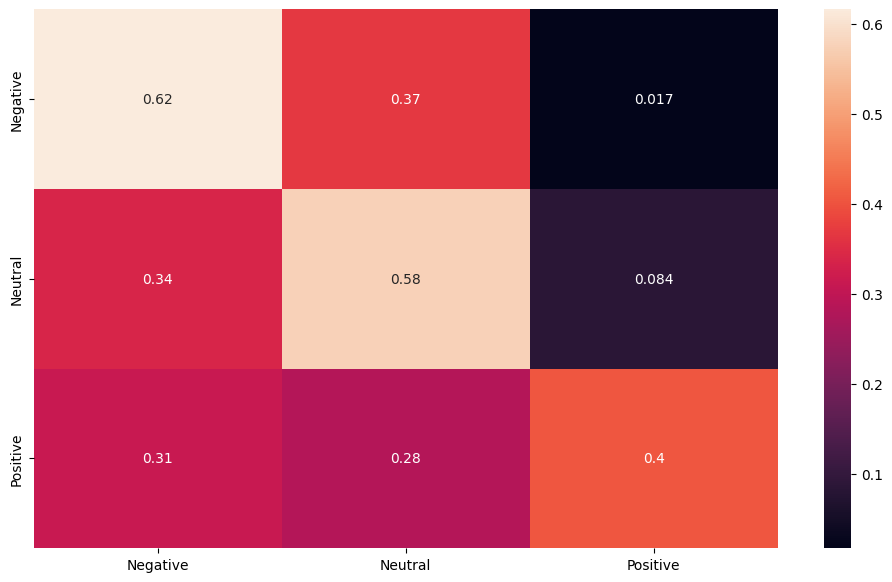

In [24]:
# Take the average of the DataFrames
average_df = pd.concat(ypred_all).groupby(level=0).mean()
print(f'Average over all k-folds: {average_df}')
plt.figure(figsize = (12,7))
sn.heatmap(average_df, annot=True)
plt.savefig('Average_kfold_baseline.png')